In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt 

from mssfp.simulations import ssfp
from mssfp.phantoms import tissue_map, shepp_logan
from mssfp.recons import gs_recon

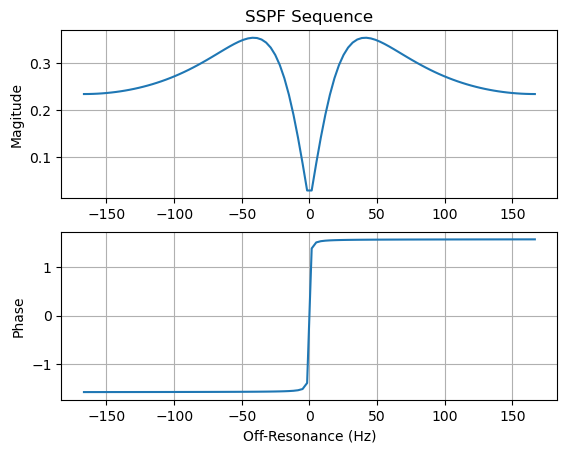

In [5]:
def ssfp_1d_example():
    T1, T2 = 1, .5
    TR, alpha = 3e-3, np.deg2rad(30)
    TE = TR / 2.0
    BetaMax = np.pi
    beta = np.linspace(-BetaMax, BetaMax, 100)
    f = beta / TR / (2 * np.pi)
    M = ssfp(T1, T2, TR, TE, alpha, f0=f)

    plt.subplot(211)
    plt.plot(f, np.absolute(M))
    plt.ylabel('Magitude')
    plt.title('SSPF Sequence')
    plt.grid(True)

    plt.subplot(212)
    plt.plot(f, np.angle(M))
    plt.xlabel('Off-Resonance (Hz)')
    plt.ylabel('Phase')
    plt.grid(True)
    plt.show()

ssfp_1d_example()

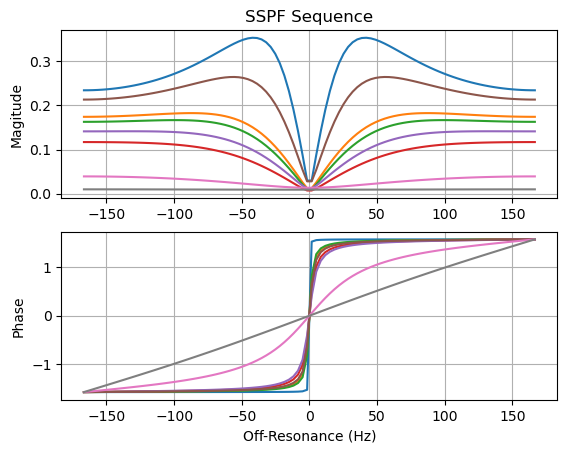

In [7]:
def ssfp_1d_example2():
    TR, alpha = 3e-3, np.deg2rad(30)
    TE = TR / 2.0
    BetaMax = np.pi
    beta = np.linspace(-BetaMax, BetaMax, 100)
    f = beta / TR / (2 * np.pi)

    keys = list(tissue_map.keys())
    M = []
    for key in keys:
        if key == 'none':
            continue
        T1 = tissue_map[key][0]
        T2 = tissue_map[key][1]
        M.append(ssfp(T1, T2, TR, TE, alpha, f0=f))
    M = np.squeeze(np.array(M))
    M = np.transpose(M, (1,0))

    plt.subplot(211)
    plt.plot(f, np.absolute(M))
    plt.ylabel('Magitude')
    plt.title('SSPF Sequence')
    plt.grid(True)

    plt.subplot(212)
    plt.plot(f, np.angle(M))
    plt.xlabel('Off-Resonance (Hz)')
    plt.ylabel('Phase')
    plt.grid(True)
    plt.show()
    
ssfp_1d_example2()

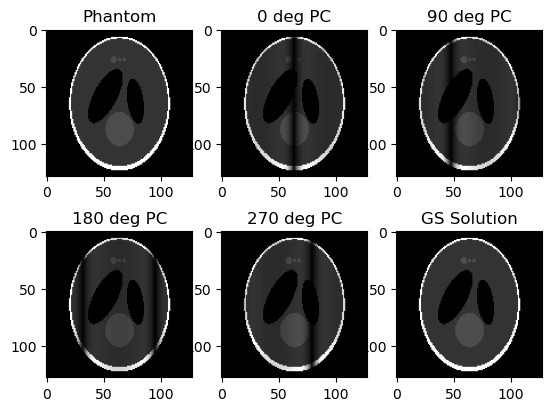

In [15]:
def ssfp_2d_example():
    N = 128
    M0 = shepp_logan(N)

    T1, T2 = M0*2, M0/2
    TR, alpha = 3e-3, np.deg2rad(30)
    TE = TR / 2.0
    pcs = np.linspace(0, 2*np.pi, 4, endpoint=False)
    df, _ = np.meshgrid(
        np.linspace(-1/TR, 1/TR, N),
        np.linspace(-1/TR, 1/TR, N))

    data = ssfp(T1, T2, TR, TE, alpha, field_map=df, dphi=pcs, M0=M0)

    # Show Phantom 
    ny, nx = 3, 2
    plt.figure()
    plt.subplot(nx, ny, 1)
    plt.imshow(M0, cmap='gray')
    plt.title('Phantom')

    # Show the phase-cycled images
    for ii in range(4):
        plt.subplot(nx, ny, ii+2)
        plt.imshow(np.abs(data[..., ii]), cmap='gray')
        plt.title('%d deg PC' % (ii*90))

    # Show the recon
    recon = gs_recon(data, pc_axis=2)
    plt.subplot(nx, ny, 6)
    plt.imshow(np.abs(recon), cmap='gray')
    plt.title('GS Solution')
    plt.show()

    return data
    
data = ssfp_2d_example()

In [9]:
print(data.shape)

(128, 128, 4)
